In [1]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t, norm, chi2, multivariate_normal
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx
import scipy.integrate as integrate
from sklearn.datasets import make_sparse_spd_matrix
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg
import utils

# Functions

In [2]:

def integrand_pair(u,S,x,T,i,j):


    T_vec = T(u)
    #a = np.diag(np.sqrt(np.reciprocal(T_vec)))
    #cov = np.dot(a,S).dot(a)
    a = np.sqrt(np.reciprocal(T_vec))
    cov = np.multiply(S, np.outer(a,a))
    A = np.sqrt(T_vec)
    return A[i]*A[j]*multivariate_normal.pdf(x, mean =np.zeros(S.shape[0]), cov = cov)

integrand_pair = np.vectorize(integrand_pair,excluded = [1,2,3,4,5])
def generalized_skew_t( x, cov, T, gamma = None, tol = 1e-4):

    gamma = np.array(gamma)
    if gamma is None:
        gamma = np.zeros(cov.shape[0])
        # cov = np.dot(np.sqrt(np.diag(np.reciprocal(T(u)))), cov).dot(np.sqrt(np.diag(np.reciprocal(T(u)))))
    integrand = lambda u: multivariate_normal.pdf(x, mean = np.reciprocal(T(u))*gamma, cov = np.multiply(cov, np.outer(np.sqrt(np.reciprocal(T(u))),np.sqrt(np.reciprocal(T(u))))) )
    integrand = np.vectorize(integrand)
    result = integrate.quadrature(integrand, 0, 1,miniter=1,tol = tol)
    return result[0]



def EM_matrix_update(theta, T, x, m, tol_skew_t= 1e-4, tol_expectation= 1e-4):
    from collections import defaultdict


    combination_calculated = defaultdict(lambda: None)
    d = theta.shape[0]
    D = np.zeros(shape = theta.shape)
    S = np.linalg.inv(theta)
    denom = generalized_skew_t(x, S, T, gamma = None,tol = tol_skew_t)

    for i in range(D.shape[0]):
        for j in range(i, D.shape[0]):
            combintaion = ''.join(sorted(str(m[i])+str(m[j])))
            if combination_calculated[combintaion] is None:
                D[i,j] =  integrate.quadrature(integrand_pair, 0, 1 ,args = (S, x, T,i,j),miniter=1,tol = tol_expectation)[0]/denom
                combination_calculated[combintaion] = D[i,j]
            else:
                D[i,j] = combination_calculated[combintaion]

    return np.triu(D,0) + np.triu(D,1).T


def generate_group_t(Sigma, nu, n):

    T = lambda u: np.array([chi2.ppf(u, df = nu[i])/nu[i] for i in range(len(nu))])

    d = Sigma.shape[0]
    x = np.random.multivariate_normal(mean = np.zeros(d),cov = Sigma, size = n)
    y = np.zeros(shape = (n, d))

    for i in range(n):


        u = np.random.uniform()
        y[i] = np.sqrt(np.reciprocal(T(u)))*x[i]

    return y



In [3]:

prec_1 = np.array([[ 1.51515152,  0.        , -1.06060606,  0.55151515],
                    [ 0.        ,  2.5       ,  0.        ,  0.        ],
                    [-1.06060606,  0.        ,  4.24242424, -0.60606061],
                    [ 0.55151515,  0.        , -0.60606061,  1.51515152]])


groups = [0,0,0,0]
nu = [4]*4
X = generate_group_t(Sigma = np.linalg.inv(prec_1), nu = nu,n = 200)
#X = multivariate_t.rvs(shape = np.linalg.inv(prec_1), df = 4, size = 100)
obs_per_graph = 100

# Group-t

In [4]:

nu_model = [nu]* 2

dg_group = dg.dygl(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.1, tol = 1e-6)
dg_group.fit(X, nr_workers=1, temporal_penalty="element-wise", lik_type="group-t", nr_em_itr = 1, time_index=range(X.shape[0]), nu = nu_model,groups = groups,tol_expectation=1e-3, tol_skew_t=1e-3)

Error 7.53E-4: 100%|██████████| 100/100 [02:28<00:00,  1.66s/it]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:278: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
Error 7.53E-4: 100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


In [5]:
dg_student = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.1, tol = 1e-6)
dg_student.fit(X, nr_workers=1, temporal_penalty="element-wise", lik_type="t", nr_em_itr = 1, time_index=range(X.shape[0]), nu = 4)

Error 1.03E-6:  31%|███▏      | 313/1000 [00:00<00:00, 1261.81it/s]


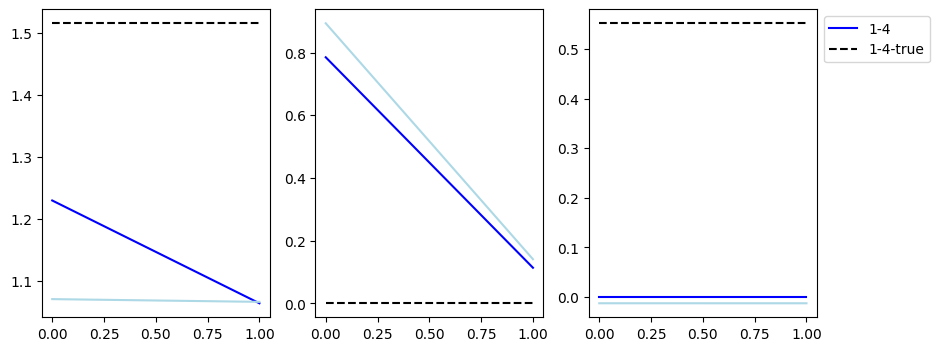

In [6]:

fig, ax = plt.subplots(1,3, figsize = (10,4))

ax[0].plot([0,1],dg_student.theta[:,0,0], label = "1-1", color = 'blue')
ax[0].plot([0,1],dg_group.theta[:,0,0], color = 'lightblue')
ax[0].plot([0,1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'black', linestyle = '--')

ax[1].plot([0,1],dg_student.theta[:,0,1], label = "1-2", color = 'blue')
ax[1].plot([0,1],dg_group.theta[:,0,1], color = 'lightblue')
ax[1].plot([0,1], [prec_1[0,1], prec_1[0,1]], label = "1-2-true", color = 'black', linestyle = '--')

ax[2].plot([0,1],dg_student.theta[:,0,3], label = "1-4", color = 'blue')
ax[2].plot([0,1],dg_group.theta[:,0,3], color = 'lightblue')
ax[2].plot([0,1], [prec_1[0,3], prec_1[0,3]], label = "1-4-true", color = 'black', linestyle = '--')


ax[2].legend(bbox_to_anchor = [1,1])


Larger dimension

In [2]:
d = 30
prec_0 = make_sparse_spd_matrix(d, alpha=0.3, smallest_coef=-0.3, largest_coef=0.3, norm_diag = True,random_state=42)

groups = [0]*d
nu = [4]*d
X = generate_group_t(Sigma = np.linalg.inv(prec_0), nu = nu,n = 60)
#X = multivariate_t.rvs(shape = np.linalg.inv(prec_1), df = 4, size = 100)
obs_per_graph = 30

NameError: name 'generate_group_t' is not defined

In [4]:

dg_group_large = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.1, tol = 1e-6)
dg_group_large.fit(X, nr_workers=2, temporal_penalty="element-wise", lik_type="group-t", nr_em_itr = 1, time_index=range(X.shape[0]), nu = nu,groups = groups,tol_expectation=1e-3, tol_skew_t=1e-3)

Error 1.48E-5: 100%|██████████| 100/100 [03:05<00:00,  1.81s/it]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:417: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
Error 1.48E-5: 100%|██████████| 100/100 [03:05<00:00,  1.85s/it]


# Skew T

In [2]:
def _T(u,nu):
    return np.array([chi2.ppf(u, df = nu[i])/nu[i] for i in range(len(nu))])


def generalized_skew_t( x, cov, nu, gamma = None, n = 10):
    """
    pdf of the generalized skew-T distribution

    Paremters
    -----------------
    x: np.array
        Vector of features /(1 observation)
    cov: np.array
        Covariance of the normal distribution
    nu: list
        Degree of freedom for each feature in x
    gamma: np.vector or None
        The addition term of the generalized skew-T distribution. If None a vector of zeros will be used
        which corresponds to the group-T distribution
    n: int
        Number of Gaussian-Qudrature terms for the integration

    """

    if gamma is None:
        gamma = np.zeros(cov.shape[0])
        # cov = np.dot(np.sqrt(np.diag(np.reciprocal(T(u)))), cov).dot(np.sqrt(np.diag(np.reciprocal(T(u)))))

    integrand = lambda u: multivariate_normal.pdf(x, mean = np.reciprocal(_T(u,nu))*gamma, cov = np.multiply(cov, np.outer(np.sqrt(np.reciprocal(_T(u,nu))),np.sqrt(np.reciprocal(_T(u,nu))))) )
    integrand = np.vectorize(integrand)
    result = integrate.fixed_quad(integrand, 0, 1,n = n)
    return result[0]

def integrand_pair(u,S,gamma,x,nu,i,j):


    T_vec = _T(u,nu)
    #a = np.diag(np.sqrt(np.reciprocal(T_vec)))
    #cov = np.dot(a,S).dot(a)
    a = np.sqrt(np.reciprocal(T_vec))
    cov = np.multiply(S, np.outer(a,a))
    mean = gamma*np.reciprocal(T_vec)

    A = np.sqrt(T_vec)
    return A[i]*A[j]*multivariate_normal.pdf(x, mean =mean, cov = cov)

integrand_pair = np.vectorize(integrand_pair,excluded = [1,2,3,4,5,6])


def EM_matrix_update(theta, x, nu,m, gamma, n = 5):
    from collections import defaultdict


    combination_calculated = defaultdict(lambda: None)
    d = theta.shape[0]
    D = np.zeros(shape = theta.shape)
    S = np.linalg.inv(theta)
    denom = generalized_skew_t(x, S,nu, gamma = gamma, n = n)

    for i in range(D.shape[0]):
        for j in range(i, D.shape[0]):
            combintaion = ''.join(sorted(str(m[i])+str(m[j])))
            if combination_calculated[combintaion] is None:
                D[i,j] =  integrate.fixed_quad(integrand_pair, 0, 1 ,args = (S,gamma, x,nu,i,j),n = n)[0]/denom
                combination_calculated[combintaion] = D[i,j]
            else:
                D[i,j] = combination_calculated[combintaion]

    return np.triu(D,0) + np.triu(D,1).T


def integrand_pair_d2(u,S,gamma,x,nu,i,j):


    T_vec = _T(u,nu)
    #a = np.diag(np.sqrt(np.reciprocal(T_vec)))
    #cov = np.dot(a,S).dot(a)
    a = np.sqrt(np.reciprocal(T_vec))
    cov = np.multiply(S, np.outer(a,a))
    mean = gamma*np.reciprocal(T_vec)

    return np.sqrt(T_vec[j])*(1/np.sqrt(T_vec[i]))*multivariate_normal.pdf(x, mean =mean, cov = cov)

integrand_pair_d2 = np.vectorize(integrand_pair_d2,excluded = [1,2,3,4,5,6])


def EM_matrix_update_d2(theta, x, nu,m, gamma, n = 5):
    from collections import defaultdict


    combination_calculated = defaultdict(lambda: None)
    d = theta.shape[0]
    D = np.zeros(shape = theta.shape)
    S = np.linalg.inv(theta)
    denom = generalized_skew_t(x, S,nu, gamma = gamma, n = n)

    for i in range(D.shape[0]):
        for j in range(D.shape[0]):
            combintaion = ''.join(sorted(str(m[i])+str(m[j])))
            if combination_calculated[combintaion] is None:
                D[i,j] =  integrate.fixed_quad(integrand_pair_d2, 0, 1 ,args = (S, gamma, x,nu,i,j),n = n)[0]/denom
                combination_calculated[combintaion] = D[i,j]
            else:
                D[i,j] = combination_calculated[combintaion]

    return D





def integrand_pair_d3(u,S,gamma,x,nu,i,j):


    T_vec = _T(u,nu)
    #a = np.diag(np.sqrt(np.reciprocal(T_vec)))
    #cov = np.dot(a,S).dot(a)
    a = np.sqrt(np.reciprocal(T_vec))
    cov = np.multiply(S, np.outer(a,a))
    mean = gamma*np.reciprocal(T_vec)

    return (1/np.sqrt(T_vec[i]))*(1/np.sqrt(T_vec[j]))*multivariate_normal.pdf(x, mean =mean, cov = cov)

integrand_pair_d3 = np.vectorize(integrand_pair_d3, excluded = [1,2,3,4,5,6])


def EM_matrix_update_d3(theta, x, nu,m,gamma,n = 5):
    from collections import defaultdict


    combination_calculated = defaultdict(lambda: None)
    d = theta.shape[0]
    D = np.zeros(shape = theta.shape)
    S = np.linalg.inv(theta)
    denom = generalized_skew_t(x, S,nu, gamma = gamma, n = n)

    for i in range(D.shape[0]):
        for j in range(i, D.shape[0]):
            combintaion = ''.join(sorted(str(m[i])+str(m[j])))
            if combination_calculated[combintaion] is None:
                D[i,j] =  integrate.fixed_quad(integrand_pair_d3, 0, 1 ,args = (S, gamma, x,nu,i,j),n = n)[0]/denom
                combination_calculated[combintaion] = D[i,j]
            else:
                D[i,j] = combination_calculated[combintaion]

    return np.triu(D,0) + np.triu(D,1).T

In [3]:
def Gaussian_update(S, A,  eta):

    """
    Update according to gaussian likelihood
    """
    AT = A.T
    M =  0.5*(A+AT)/eta - S
    D, Q = np.linalg.eig(M)
    diag_m = np.diag(D+np.sqrt(D**2 + 4.0/eta))
    return np.real(0.5*eta*np.dot(Q, diag_m).dot(Q.T))



def em_iteration(X,A, A_gamma, theta_init, nu, rho_gamma, eta, gamma, groups = None,n = 5, tol = 1e-10 ,yes = True  ):
    d = X.shape[1]
    iteration = 0

    while iteration < 1:
        # E-step
        x = X
        S = np.zeros(shape = (d,d))
        G1 = np.zeros(shape = d)
        G2 = np.zeros(shape = (d,d))
        #print("starting E-step")
        for i in range(x.shape[0]):
            # print(i)
            D_1 = EM_matrix_update(theta_init,x[i],nu,groups, gamma, n)
            D_2 = EM_matrix_update_d2(theta_init,x[i],nu,groups, gamma, n)
            D_3 = EM_matrix_update_d3(theta_init,x[i],nu,groups, gamma, n)

            #D_1 = np.outer(np.sqrt(V[i]), np.sqrt(V[i]))
            #D_2 = np.outer(np.sqrt(1/V[i]), np.sqrt(V[i]))
            #D_3 = np.outer(np.sqrt(1/V[i]), np.sqrt(1/V[i]))

            S +=  (np.multiply(np.outer(x[i],x[i]),D_1 )-np.multiply(np.outer(gamma,x[i]),D_2 )-np.multiply(np.outer(x[i],gamma),D_2.T )+np.multiply(np.outer(gamma,gamma),D_3 ) )/float(x.shape[0])
            #S +=  np.dot(np.diag(np.sqrt(V[i])), np.outer(x[i],x[i])).dot(np.diag(np.sqrt(V[i])))/float(x.shape[0])
            #S -= np.dot(np.diag(np.sqrt(1/V[i])), np.outer(gamma,x[i])).dot(np.diag(np.sqrt(V[i])))/float(x.shape[0])
            #S -= np.dot(np.diag(np.sqrt(V[i])), np.outer(x[i],gamma)).dot(np.diag(np.sqrt(1/V[i])))/float(x.shape[0])
            #S +=  np.dot(np.diag(np.sqrt(1/V[i])), np.outer(gamma,gamma)).dot(np.diag(np.sqrt(1/V[i])))/float(x.shape[0])
            
            G1 += np.multiply(theta_init, D_2).dot(x[i])
            G2 += D_3

            #G1 += np.dot(np.diag(np.sqrt(1/V[i])), theta_init).dot(np.diag(np.sqrt(V[i]))).dot(X[i])
            #G2 += np.dot(np.diag(np.sqrt(1/V[i])), theta_init).dot(np.diag(np.sqrt(1/V[i])))


        # M-step
        theta_new = Gaussian_update(S, A, eta)
        #theta_new= theta_init #Gaussian_update(S, A, eta)
        if yes:
            gamma_new = np.dot(np.linalg.inv(np.multiply(theta_new, G2)+rho_gamma*np.identity(d)), G1 +rho_gamma*A_gamma)
        else:
            gamma_new = np.dot(np.linalg.inv(np.multiply(theta_new, G2)), G1 )
        #gamma_new = np.dot(np.linalg.inv(G2), G1)
        # gamma_new = gamma
        fro = np.linalg.norm(theta_new - theta_init)
        if fro < tol:
            theta_init = theta_new.copy()
            break
        iteration+=1


    return theta_new, gamma_new,  G1, G2



def soft_threshold_odd( A, lamda):

    """
    diagonal lasso penalty

    Parameters
    ------------------
    A: np.array,
    
    lamda: float,
        regularization
    """
    opt_m = (A-lamda)*(A>=lamda) + (A+lamda)*(A<=-lamda)
    

    return opt_m

def generate_skew_t(Sigma, gamma, nu, n):

    

    d = Sigma.shape[0]
    x = np.random.multivariate_normal(mean = np.zeros(d),cov = Sigma, size = n)
    y = np.zeros(shape = (n, d))

    for i in range(n):
        
        u = np.random.uniform()
        v = chi2.ppf(u, df = nu)/nu 

        u = np.random.uniform()
        y[i] = (1/v)*gamma+ np.sqrt(1/v)*x[i]

    return y



def generate_gen_skew_t(Sigma, gamma, nu, n):
    from scipy.stats import uniform

    T = lambda u: np.array([chi2.ppf(u, df = nu[k])/nu[k] for k in range(len(nu))])

    d = Sigma.shape[0]
    x = np.random.multivariate_normal(mean = np.zeros(d),cov = Sigma, size = n)
    y = np.zeros(shape = (n, d))

    V = np.zeros(shape = (n, d))

    for i in range(n):


        u = uniform.rvs()
        y[i] = np.reciprocal(T(u))*gamma  + np.sqrt(np.reciprocal(T(u)))*x[i]
        V[i] = T(u)

    return y, V







In [4]:

d = 20
G =nx.erdos_renyi_graph(d, 0.35, seed=42)
A = np.array(nx.adjacency_matrix(G).todense())
A[np.tril_indices(d)] = 0
U = np.random.binomial(1,0.5,  size = (d,d))
A = np.multiply(A, U*np.random.uniform(-0.6,-0.2, size = (d,d)) + (1-U)*np.random.uniform(0.2,0.6, size = (d,d)))
A = A+A.T
np.fill_diagonal(A, np.sum(np.abs(A),axis=1))

A2 = A.copy()
A2_SIGNS = np.sign(A2)
A2 = np.power(np.abs(A2), 1.3)
A2 = A2*A2_SIGNS
np.fill_diagonal(A2,np.diag(A))
np.round(A2[:,1],2)


obs_per_graph = 100
n = 300   

gamma = np.array([0.05] * 10 + [0.1]*5 + [-0.05]*5)
nu = [4]*5 + [5]*5 + [8]*5 + [10]*5
groups= [0]*5 + [1]*5 + [2]*5 + [3]*5
X1,_ = generate_gen_skew_t(np.linalg.inv(A),gamma = gamma,nu = nu, n = n)
X2,_ = generate_gen_skew_t(np.linalg.inv(A2),gamma = gamma,nu = nu, n = n)
X = np.vstack((X1,X2))

C:\Users\User\AppData\Local\Temp\ipykernel_33628\1160887470.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(G).todense())


In [22]:
X_s = np.random.multivariate_normal(mean = np.zeros(d),cov = np.linalg.inv(A), size=1000)
scipy.stats.kurtosis(X_s,bias=False)

array([ 0.28575168, -0.07713899, -0.22998419, -0.07698016,  0.2306333 ,
        0.28372652,  0.11095895, -0.1358915 , -0.30954699,  0.14903168,
        0.0120825 ,  0.0294952 , -0.09962463,  0.09774654, -0.15089292,
       -0.11134489, -0.23861478, -0.03900448, -0.16490128,  0.02302345])

In [11]:
# static test
X_s = np.random.multivariate_normal(mean = np.zeros(d),cov = np.linalg.inv(A), size=20)
sgl_n = dg.sgl( max_iter = 1000, lamda = X_s.shape[0]*0.05, tol = 1e-6)
# sgl_n.fit(X_s, lik_type="group-t", True_prec = [A], nu = [4]*d, groups = [0]*d)


KeyboardInterrupt: 

In [5]:
dg_opt_t = dg.dygl(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.1, kappa_gamma=obs_per_graph*0.1, tol = 1e-6)
dg_opt_t.fit(X, nr_workers=6, temporal_penalty="element-wise", lik_type="t", True_prec = [A,A,A,A2,A2,A2], time_index=range(X.shape[0]), nu = 4)

Error 1.88E-5, F 3.341E-1: 100%|█████████▉| 999/1000 [00:04<00:00, 304.04it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:263: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
Error 1.88E-5, F 3.341E-1: 100%|██████████| 1000/1000 [00:04<00:00, 216.17it/s]


In [6]:
True_prec = [A,A,A,A2,A2,A2]
np.mean([utils.calc_f1(True_prec[k], dg_opt_t.theta[k]) for k in range(len(True_prec))])

0.8190813951605551

In [31]:
dg_opt1 = dg.dygl(obs_per_graph = obs_per_graph, max_iter = 20, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.1, kappa_gamma=obs_per_graph*0.1, tol = 1e-6)
dg_opt1.fit(X, nr_workers=6, temporal_penalty="element-wise", theta_init = dg_opt_t.theta.copy(), lik_type="skew-group-t", True_prec = [A,A,A,A2,A2,A2], time_index=range(X.shape[0]), nu = nu, groups = groups,nr_quad = 5)

Error 2.58E-1, F 3.272E-1:  55%|█████▌    | 11/20 [1:23:26<1:05:00, 433.39s/it]

In [8]:
True_prec = [A,A,A,A2,A2,A2]
np.mean([utils.calc_f1(True_prec[k], dg_opt1.theta[k]) for k in range(len(True_prec))])

array([[-0.03,  0.06,  0.06,  0.1 ,  0.02,  0.03,  0.09, -0.04,  0.06,
         0.08,  0.08,  0.18,  0.04,  0.06,  0.05,  0.01, -0.07, -0.08,
        -0.06,  0.  ],
       [-0.04,  0.09,  0.09,  0.07,  0.04,  0.05, -0.  ,  0.05, -0.02,
        -0.02,  0.13,  0.06,  0.04,  0.04,  0.08, -0.06, -0.07, -0.17,
         0.  , -0.14],
       [ 0.05,  0.03,  0.03,  0.01,  0.01, -0.02,  0.09, -0.02,  0.07,
         0.01,  0.02,  0.06, -0.  ,  0.  ,  0.05,  0.02, -0.03, -0.09,
        -0.1 , -0.06],
       [ 0.07,  0.06,  0.05,  0.08,  0.07, -0.02,  0.09,  0.01,  0.04,
         0.05,  0.11,  0.04,  0.11,  0.12,  0.01,  0.03, -0.05,  0.05,
        -0.1 , -0.03],
       [-0.01,  0.  ,  0.03, -0.03,  0.13,  0.03,  0.05,  0.04, -0.04,
         0.1 ,  0.01,  0.08,  0.09,  0.1 ,  0.07,  0.02, -0.03, -0.04,
        -0.06, -0.03],
       [ 0.05,  0.06,  0.04,  0.16, -0.04,  0.03,  0.08,  0.05,  0.08,
         0.09,  0.05,  0.13,  0.09,  0.12,  0.11, -0.01, -0.08,  0.01,
        -0.11, -0.08]])

In [7]:
dg_opt2 = dg.dygl(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.1, kappa = obs_per_graph*0.1, kappa_gamma=obs_per_graph*0.1, tol = 1e-6)
dg_opt2.fit(X, nr_workers=2, temporal_penalty="element-wise", theta_init = dg_opt_t.theta.copy(), lik_type="group-t", True_prec = [A]*2, time_index=range(X.shape[0]), nu = nu, groups = groups,nr_quad = 10)

Error 1.32E-4, F 4.406E-1: 100%|██████████| 100/100 [3:16:03<00:00, 30.75s/it]  C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:287: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
Error 1.32E-4, F 4.406E-1: 100%|██████████| 100/100 [3:16:03<00:00, 117.63s/it]


In [12]:
from utils import calc_f1
f1_t = np.mean([calc_f1(A, dg_opt_t.theta[k]) for k in range(len(dg_opt_t.theta))])
f1_gt = np.mean([calc_f1(A, dg_opt1.theta[k]) for k in range(len(dg_opt1.theta))])
f1_gt2 = np.mean([calc_f1(A, dg_opt2.theta[k]) for k in range(len(dg_opt2.theta))])
print(f1_t)
print(f1_gt)
print(f1_gt2)

0.7766039051603905
0.7765438125457652
0.7866769547325103


In [23]:

F_t = np.mean([scipy.linalg.norm(A-dg_opt_t.theta[k], ord = 'fro')/scipy.linalg.norm(A, ord = 'fro') for k in range(len(dg_opt_t.theta))])
F_gt = np.mean([scipy.linalg.norm(A-dg_opt1.theta[k], ord = 'fro')/scipy.linalg.norm(A, ord = 'fro') for k in range(len(dg_opt1.theta))])
print(F_t)
print(F_gt)

0.14082924034283212
0.11105880663698495


In [104]:
from decimal import Decimal
n_t = 100
nr_graphs = int(n/n_t)

u0 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
u1 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
u2 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

u1_g = np.zeros((nr_graphs, X.shape[1]))
# u1_g[-1] = np.zeros(X.shape[1])
u2_g = np.zeros((nr_graphs, X.shape[1]))
#u2_g[0] = np.zeros(X.shape[1])

z0 = np.ones((nr_graphs, X.shape[1], X.shape[1]))
z1 =   np.zeros((nr_graphs, X.shape[1], X.shape[1]))
z2 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

z1_g =   np.zeros((nr_graphs, X.shape[1]))
z2_g = np.zeros((nr_graphs, X.shape[1]))

theta = np.array([np.identity(X.shape[1]) for _ in range(nr_graphs) ])
gamma_est = 0*np.ones(shape = (nr_graphs,X.shape[1]))

thetas_pre = theta.copy()


def get_A(i):
    if i == 0 or i == nr_graphs-1:
        A = (z0[i] + z1[i] + z2[i] - u0[i] - u1[i] - u2[i])/2.0
    else:
        A = (z0[i] + z1[i] + z2[i] - u0[i] - u1[i] - u2[i])/3.0
    return A

def get_A_gamma(i):
    return  z1_g[i] + z2_g[i] - u1_g[i] - u2_g[i]


kappa = 0.3*n_t
lamda = 0.05*n_t
rho = n_t
rho_gamma = n_t
kappa_gamma =0.3*rho_gamma

nr_its = 10

pbar = tqdm.tqdm(total = nr_its)

iteration=0
while iteration < nr_its:
    

    for i in range(nr_graphs):
        if (i == nr_graphs-1) or (i == 0):
            eta = n_t/rho/2.0
        else:
            eta = n_t/rho/3.0
        theta[i], gamma_est[i], G1,G2 = em_iteration(X[n_t*i:(i+1)*n_t], get_A(i), get_A_gamma(i), theta[i].copy(),nu, rho_gamma, eta, gamma_est[i].copy(), groups, n = 10, yes = True)
    
    for i in range(nr_graphs):
        z0[i] = soft_threshold_odd(theta[i]+u0[i], lamda/rho)
        np.fill_diagonal(z0[i], np.diag(theta[i]+u0[i]))

    # update z1, z2
    for i in range(1,nr_graphs):
        A = theta[i]-theta[i-1]+u2[i]-u1[i-1]
        E = soft_threshold_odd(A, 2*kappa/rho)
        summ = 0.5*(theta[i]+theta[i-1]+u1[i-1]+u2[i])
        z1[i-1] = summ - 0.5*E
        z2[i] = summ + 0.5*E

        A_gamma = gamma_est[i]-gamma_est[i-1]+u2_g[i]-u1_g[i-1]
        E = soft_threshold_odd(A_gamma, 2*kappa_gamma/rho_gamma)
        summ = 0.5*(gamma_est[i]+gamma_est[i-1]+u1_g[i-1]+u2_g[i])
        z1_g[i-1] = summ - 0.5*E
        z2_g[i] = summ + 0.5*E

    u0 = u0 + theta - z0
    u1[:(nr_graphs-1)] = u1[:(nr_graphs-1)] + theta[:(nr_graphs-1)]-z1[:(nr_graphs-1)]
    u2[1:] = u2[1:] + theta[1:] - z2[1:]

    u1_g[:(nr_graphs-1)] = u1_g[:(nr_graphs-1)] + gamma_est[:(nr_graphs-1)]-z1_g[:(nr_graphs-1)]
    u2_g[1:] = u2_g[1:] + gamma_est[1:] - z2_g[1:]


    fro_norm = 0.0
    for i in range(nr_graphs):
        dif = theta[i] - thetas_pre[i]
        fro_norm += np.linalg.norm(dif)


    pbar.set_description(f"Error {Decimal(fro_norm):.2E} {np.round(gamma_est[0],2)} {np.round(gamma_est[1],2)}")
    pbar.update()

    thetas_pre = theta.copy()


    iteration+= 1

pbar.close()



Error 1.30E-6 [-0.08  0.06 -0.05 -0.02] [-0.08  0.08 -0.01 -0.02]: 100%|██████████| 500/500 [14:41<00:00,  1.76s/it]


In [96]:
from decimal import Decimal
n_t = 25
nr_graphs = int(n/n_t)

u0 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
u1 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))
u2 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

u1_g = np.zeros((nr_graphs, X.shape[1]))
# u1_g[-1] = np.zeros(X.shape[1])
u2_g = np.zeros((nr_graphs, X.shape[1]))
#u2_g[0] = np.zeros(X.shape[1])

z0 = np.ones((nr_graphs, X.shape[1], X.shape[1]))
z1 =   np.zeros((nr_graphs, X.shape[1], X.shape[1]))
z2 = np.zeros((nr_graphs, X.shape[1], X.shape[1]))

z1_g =   np.zeros((nr_graphs, X.shape[1]))
z2_g = np.zeros((nr_graphs, X.shape[1]))

theta = np.array([np.identity(X.shape[1]) for _ in range(nr_graphs) ])
gamma_est = 0*np.ones(shape = (nr_graphs,X.shape[1]))


thetas_pre = theta.copy()
def get_A(i):
    if i == 0 or i == nr_graphs-1:
        A = (z0[i] + z1[i] + z2[i] - u0[i] - u1[i] - u2[i])/2.0
    else:
        A = (z0[i] + z1[i] + z2[i] - u0[i] - u1[i] - u2[i])/3.0
    return A

def get_A_gamma(i):


    return  z1_g[i] + z2_g[i] - u1_g[i] - u2_g[i]


kappa = 0.3*n_t
lamda = 0.05*n_t
rho =n_t
rho_gamma = 1
kappa_gamma =0.3*rho_gamma

nr_its = 500

pbar = tqdm.tqdm(total = nr_its)

iteration=0
while iteration < nr_its:
    

    for i in range(nr_graphs):
        if (i == nr_graphs-1) or (i == 0):
            eta = n_t/rho/2.0
        else:
            eta = n_t/rho/3.0
        theta[i], gamma_est[i], G1,G2 = em_iteration(X[n_t*i:(i+1)*n_t], get_A(i), get_A_gamma(i), theta[i].copy(),nu, rho_gamma, eta, gamma_est[i].copy(), groups, n = 5, yes = False)
    
    for i in range(nr_graphs):
        z0[i] = soft_threshold_odd(theta[i]+u0[i], lamda/rho)
        np.fill_diagonal(z0[i], np.diag(theta[i]+u0[i]))

    # update z1, z2
    for i in range(1,nr_graphs):
        A = theta[i]-theta[i-1]+u2[i]-u1[i-1]
        E = soft_threshold_odd(A, 2*kappa/rho)
        summ = 0.5*(theta[i]+theta[i-1]+u1[i-1]+u2[i])
        z1[i-1] = summ - 0.5*E
        z2[i] = summ + 0.5*E

        A_gamma = gamma_est[i]-gamma_est[i-1]+u2_g[i]-u1_g[i-1]
        E = soft_threshold_odd(A_gamma, 2*kappa_gamma/rho_gamma)
        summ = 0.5*(gamma_est[i]+gamma_est[i-1]+u1_g[i-1]+u2_g[i])
        z1_g[i-1] = summ - 0.5*E
        z2_g[i] = summ + 0.5*E

    u0 = u0 + theta - z0
    u1[:(nr_graphs-1)] = u1[:(nr_graphs-1)] + theta[:(nr_graphs-1)]-z1[:(nr_graphs-1)]
    u2[1:] = u2[1:] + theta[1:] - z2[1:]

    u1_g[:(nr_graphs-1)] = u1_g[:(nr_graphs-1)] + gamma_est[:(nr_graphs-1)]-z1_g[:(nr_graphs-1)]
    u2_g[1:] = u2_g[1:] + gamma_est[1:] - z2_g[1:]


    fro_norm = 0.0
    for i in range(nr_graphs):
        dif = theta[i] - thetas_pre[i]
        fro_norm += np.linalg.norm(dif)


    pbar.set_description(f"Error {Decimal(fro_norm):.2E} {np.round(gamma_est[0],2)} {np.round(gamma_est[1],2)}")
    pbar.update()

    thetas_pre = theta.copy()


    iteration+= 1

pbar.close()



Error 1.05E-6 [-0.04 -0.   -0.1  -0.12] [-0.12  0.14  0.05  0.07]: 100%|██████████| 500/500 [14:46<00:00,  1.77s/it]


In [103]:
pbar.close()

In [89]:
print(np.round(theta[0],2))
print(np.round(gamma_est[0],2))

[[ 1.52 -0.   -1.32  0.21]
 [-0.    2.62  0.   -0.05]
 [-1.32  0.    2.19 -0.31]
 [ 0.21 -0.05 -0.31  1.32]]
[-0.04 -0.   -0.11 -0.13]


In [22]:
print(np.round(theta[1],2))
print(np.round(gamma_est[1],2))

[[ 0.37 -0.24 -0.09  0.25]
 [-0.24  0.53  0.37 -0.17]
 [-0.09  0.37  0.34 -0.13]
 [ 0.25 -0.17 -0.13  0.61]]
[ 4.17  3.57 -8.16  1.8 ]


In [137]:
print(np.round(theta[4],2))
print(np.round(gamma_est[4],2))

IndexError: index 4 is out of bounds for axis 0 with size 2

In [52]:
prec_1

array([[ 1.51515152,  0.        , -1.06060606,  0.55151515],
       [ 0.        ,  2.5       ,  0.        ,  0.        ],
       [-1.06060606,  0.        ,  2.24242424, -0.60606061],
       [ 0.55151515,  0.        , -0.60606061,  1.51515152]])

only EM for Gamma

In [370]:
from decimal import Decimal
n_t = 200
nr_graphs = int(n/n_t)

theta = np.array([prec_1 for _ in range(nr_graphs) ])
z0 = np.array([prec_1 for _ in range(nr_graphs) ])
z1 = np.array([prec_1 for _ in range(nr_graphs) ])
z2 = np.array([prec_1 for _ in range(nr_graphs) ])

thetas_pre = theta.copy()
def get_A( i):
    if i == 0 or i == nr_graphs-1:
        A = (z0[i] + z1[i] + z2[i] - u0[i] - u1[i] - u2[i])/2.0
    else:
        A = (z0[i] + z1[i] + z2[i] - u0[i] - u1[i] - u2[i])/3.0
    return A


kappa = 0.1
lamda = 0.1
rho =n_t

nr_its = 100
gamma_est = np.zeros(shape = (nr_graphs,X.shape[1]))

pbar = tqdm.tqdm(total = nr_its)

iteration=0
while iteration < nr_its:

    for i in range(nr_graphs):
        if i == nr_graphs-1 or i == 0:
            eta = n_t/rho/2.0
        else:
            eta = n_t/rho/3.0
        _, gamma_est[i] = em_iteration(X[n_t*i:(i+1)*n_t], get_A(i),theta[i],nu, rho, eta, gamma_est[i], groups, n = 5)


    pbar.set_description(f"Error {Decimal(fro_norm):.2E}")
    pbar.update()

    thetas_pre = theta.copy()


    iteration+= 1
    print(gamma_est[0])

pbar.close()



Error 1.97E+0:   0%|          | 4/1000 [00:57<3:56:34, 14.25s/it]


KeyboardInterrupt: 

In [13]:
z0[i]

array([[ 1.51515152,  0.        , -1.06060606,  0.55151515],
       [ 0.        ,  2.5       ,  0.        ,  0.        ],
       [-1.06060606,  0.        ,  2.24242424, -0.60606061],
       [ 0.55151515,  0.        , -0.60606061,  1.51515152]])

In [12]:
gamma_est

array([[ 0.02713184, -1.34183117,  0.61296905,  0.13419843],
       [ 0.21190639, -0.64517196, -0.93636545,  0.53578898]])

In [115]:
pbar.close()

In [100]:
prec_1

array([[ 1.51515152,  0.        , -1.06060606,  0.55151515],
       [ 0.        ,  2.5       ,  0.        ,  0.        ],
       [-1.06060606,  0.        ,  2.24242424, -0.60606061],
       [ 0.55151515,  0.        , -0.60606061,  1.51515152]])

In [117]:
np.round(theta[1],2)

array([[ 1.2 , -0.08, -0.84,  0.4 ],
       [-0.08,  2.13,  0.06, -0.07],
       [-0.84,  0.06,  1.79, -0.43],
       [ 0.4 , -0.07, -0.43,  1.23]])

# Integration Test

Functions

In [91]:

def integrand_pair(u,S,x,T,i,j):


    T_vec = T(u)
    a = np.sqrt(np.reciprocal(T_vec))
    cov = np.multiply(S, np.outer(a,a))
    A = np.sqrt(T_vec)
    return A[i]*A[j]*multivariate_normal.pdf(x, mean =np.zeros(S.shape[0]), cov = cov)


integrand_pair = np.vectorize(integrand_pair,excluded = [1,2,3,4,5])
def generalized_skew_t( x, cov, T, gamma = None):

    if gamma is None:
        gamma = np.zeros(cov.shape[0])
        # cov = np.dot(np.sqrt(np.diag(np.reciprocal(T(u)))), cov).dot(np.sqrt(np.diag(np.reciprocal(T(u)))))
    integrand = lambda u: multivariate_normal.pdf(x, mean = np.dot(np.diag(np.reciprocal(T(u))), gamma), cov = np.multiply(cov, np.outer(np.sqrt(np.reciprocal(T(u))),np.sqrt(np.reciprocal(T(u))))) )
    integrand = np.vectorize(integrand)
    result = integrate.fixed_quad(integrand, 0, 1,n = 10)
    return result[0]



def EM_matrix_update(theta, T, x, m):
    from collections import defaultdict


    combination_calculated = defaultdict(lambda: None)
    d = theta.shape[0]
    D = np.zeros(shape = theta.shape)
    S = np.linalg.inv(theta)
    denom = generalized_skew_t(x, S, T, gamma = None)

    for i in range(D.shape[0]):
        for j in range(i, D.shape[0]):
            combintaion = ''.join(sorted(str(m[i])+str(m[j])))
            if combination_calculated[combintaion] is None:
                D[i,j] =  integrate.fixed_quad(integrand_pair, 0, 1 ,args = (S, x, T,i,j),n=10)[0]/denom
                combination_calculated[combintaion] = D[i,j]
            else:
                D[i,j] = combination_calculated[combintaion]

    return np.triu(D,0) + np.triu(D,1).T


def generate_group_t(Sigma, nu, n):

    T = lambda u: np.array([chi2.ppf(u, df = nu[i])/nu[i] for i in range(len(nu))])

    d = Sigma.shape[0]
    x = np.random.multivariate_normal(mean = np.zeros(d),cov = Sigma, size = n)
    y = np.zeros(shape = (n, d))

    for i in range(n):


        u = np.random.uniform()
        y[i] = np.sqrt(np.reciprocal(T(u)))*x[i]

    return y






In [125]:
def integrand_pair2(u,theta,x,T,i,j):


    T_vec = T(u)
    a = np.sqrt(T_vec)
    prec = np.multiply(theta, np.outer(a,a))
    A = np.sqrt(T_vec)
    # C = 1/np.sqrt((1/np.linalg.det(prec))*(2*np.pi) ** d)
    return np.sqrt(np.prod(T_vec))*A[i]*A[j]*np.exp(-0.5*np.dot(x, prec).dot(x))

integrand_pair2 = np.vectorize(integrand_pair2,excluded = [1,2,3,4,5])


def gen_skew_t_integrand(u, theta,x,T,gamma):
    T_vec = T(u)

    mean = np.dot(np.diag(np.reciprocal(T_vec)), gamma)
    a = np.sqrt(T_vec)
    prec = np.multiply(theta, np.outer(a,a))
    return np.sqrt(np.prod(T_vec))*np.exp(-0.5*np.dot(x-mean, prec).dot(x-mean))


gen_skew_t_integrand = np.vectorize(gen_skew_t_integrand,excluded = [1,2,3,4])


def generalized_skew_t2( x, theta, T, gamma = None):

    if gamma is None:
        gamma = np.zeros(theta.shape[0])

    C = 1/np.sqrt((1/np.linalg.det(theta))*(2*np.pi) ** d)
    result = integrate.fixed_quad(gen_skew_t_integrand, 0, 1,args = (theta, x, T, gamma),n = 10)
    return C*result[0]



def EM_matrix_update2(theta, T, x, m, tol_skew_t= 1e-4, tol_expectation= 1e-4):
    from collections import defaultdict


    combination_calculated = defaultdict(lambda: None)
    d = theta.shape[0]
    D = np.zeros(shape = theta.shape)
    denom = generalized_skew_t2(x,theta,T)
    C = 1/np.sqrt((1/np.linalg.det(theta))*(2*np.pi) ** d)
    for i in range(D.shape[0]):
        for j in range(i, D.shape[0]):
            combintaion = ''.join(sorted(str(m[i])+str(m[j])))
            if combination_calculated[combintaion] is None:
                D[i,j] =  C*integrate.fixed_quad(integrand_pair2, 0, 1 ,args = (theta, x, T,i,j),n=10)[0]/denom
                combination_calculated[combintaion] = D[i,j]
            else:
                D[i,j] = combination_calculated[combintaion]

    return np.triu(D,0) + np.triu(D,1).T

In [85]:
nu = [4,4,4]
m = [0,0,0]

T = lambda u: np.array([chi2.ppf(u, df = nu[i])/nu[i] for i in range(len(nu))])

d = 3
theta = np.array([[1,0.3,0.3], [0.3, 1, 0.3], [0.3, 0.3, 1]])
# x =np.random.multivariate_normal(mean = np.zeros(theta.shape[0]), cov = np.linalg.inv(theta))
x = multivariate_t.rvs(shape = np.linalg.inv(theta), df = 4)
S = np.linalg.inv(theta)

for i in range(1):
    C = 1/np.sqrt((1/np.linalg.det(theta))*(2*np.pi) ** d)
    result = C*integrate.quad(integrand_pair2, 0, 1 ,args = (theta, x, T,0,0))[0]/generalized_skew_t2(x, S, T, gamma = None)
    #print(result)

generalized_skew_t2(x,theta,T)

0.010184553141997307

True student-T

In [74]:
for i in range(50):
    result = integrate.quad(integrand_pair, 0, 1 ,args = (S, x, T,0,0))[0]/generalized_skew_t(x, S, T, gamma = None)
    #print(result)

In [12]:
nu = [4,4,4]
m = [0,0,0]

T = lambda u: np.array([chi2.ppf(u, df = nu[i])/nu[i] for i in range(len(nu))])


theta = np.array([[1,0.3,0.3], [0.3, 1, 0.3], [0.3, 0.3, 1]])
# x =np.random.multivariate_normal(mean = np.zeros(theta.shape[0]), cov = np.linalg.inv(theta))
x = multivariate_t.rvs(shape = np.linalg.inv(theta), df = 4)
S = np.linalg.inv(theta)


result = integrate.quad(integrand_pair, 0, 1 ,args = (S,x, T,0,0))[0]/multivariate_t.pdf(x , loc = np.zeros(3), df=nu[0], shape = S)#generalized_skew_t(x, np.linalg.inv(theta), T, gamma = None)
print(result)

result = integrate.quad(integrand_pair, 0, 1 ,args = (S, x, T,0,0))[0]/generalized_skew_t(x, S, T, gamma = None)
print(result)

M = np.dot(x, theta).dot(x.T)
print((nu[0] + 3)/ (nu[0] + M))

1.5424089298539803
1.5435968533865236
1.5424089307487696


Now with all pair

In [106]:

D = EM_matrix_update(theta, T, x, m)
D2 = EM_matrix_update2(theta, T, x, m)
#print(np.multiply(D, np.outer(x,x)))
M = np.dot(x, theta).dot(x.T)
v = (nu[0] + theta.shape[0])/ (nu[0] + M)
#print(v*np.outer(x,x))

print(v)
print(D[0,0])
print(D2[0,0])

1.0256602068013023
1.0264880767097335
1.0264880767097335


Time complexity

In [114]:
for _ in range(100):
    #print(_)
    D = EM_matrix_update(theta, T, x, m)

In [115]:
for _ in range(100):
    # print(_)
    D = EM_matrix_update2(theta, T, x, m)

Works for student-T. Let's try group t

In [122]:
theta = np.array([[1,0.3,0.3], [0.3, 1, 0.3], [0.3, 0.3, 1]])
Sigma = np.linalg.inv(theta)
nu = [4,4,8]

x = generate_group_t(S,nu,1)

In [123]:
m = [0,0,1]
T = lambda u: np.array([chi2.ppf(u, df = nu[i])/nu[i] for i in range(len(nu))])
D = EM_matrix_update(theta, T, x[0], m)
print(np.multiply(D, np.outer(x,x)))

[[ 0.09905847 -0.57320577  0.15622937]
 [-0.57320577  3.31687787 -0.90402745]
 [ 0.15622937 -0.90402745  0.24803621]]


In [126]:
m = [0,0,1]
T = lambda u: np.array([chi2.ppf(u, df = nu[i])/nu[i] for i in range(len(nu))])
D = EM_matrix_update2(theta, T, x[0], m)
print(np.multiply(D, np.outer(x,x)))

[[ 0.09905847 -0.57320577  0.15622937]
 [-0.57320577  3.31687787 -0.90402745]
 [ 0.15622937 -0.90402745  0.24803621]]


In [132]:
for _ in range(100):
    #print(_)
    D = EM_matrix_update(theta, T, x, m)

In [133]:
for _ in range(100):
    # print(_)
    D = EM_matrix_update2(theta, T, x[0], m)

scale up

In [8]:
from sklearn.datasets import make_sparse_spd_matrix
d = 50
prec_0 = make_sparse_spd_matrix(d, alpha=0.3, smallest_coef=-0.3, largest_coef=0.3, norm_diag = True,random_state=42)
#print("precision")
#print(prec_0)
#print("Covariance")
S = np.linalg.inv(prec_0)

nu = [4,4,4]
m = [0]*d #[0]*(d-30) + [1]*20 + [2]*10

x = multivariate_t.rvs(shape = np.linalg.inv(prec_0), df = 4) #generate_group_t(S,nu,m,1)
T = lambda u: np.array([chi2.ppf(u, df = nu[m[i]])/nu[m[i]] for i in range(len(m))])



D = EM_matrix_update(prec_0, T, x, m)
#print(np.round(np.multiply(D, np.outer(x,x)),3))
M = np.dot(x, prec_0).dot(x.T)
v = (nu[0] + d)/ (nu[0] + M)
#print(np.round(v*np.outer(x,x),3))


print(D[0,0])
print(v)


0.4278096309651343
0.5257524423537892


In [190]:
generalized_skew_t(x,S,T)

8.284778116013363e-34

In [314]:
for _ in range(5):
    print(_)
    EM_matrix_update(prec_0, T, x, m)

0
1
2
3
4


In [217]:
for _ in range(10):
    gamma = np.zeros(S.shape[0])
    # cov = np.dot(np.sqrt(np.diag(np.reciprocal(T(u)))), cov).dot(np.sqrt(np.diag(np.reciprocal(T(u)))))
    integrand = lambda u: multivariate_normal.pdf(x, mean = np.dot(np.diag(np.reciprocal(T(u))), gamma), cov = np.multiply(S, np.outer(np.sqrt(np.reciprocal(T(u))),np.sqrt(np.reciprocal(T(u))))) )
    integrand = np.vectorize(integrand)
    result = integrate.quadrature(integrand, 0, 1)
    result[0]

Try estimation

In [11]:
prec_1 = np.array([[ 1.51515152,  0.        , -1.06060606,  0.55151515],
                    [ 0.        ,  2.5       ,  0.        ,  0.        ],
                    [-1.06060606,  0.        ,  4.24242424, -0.60606061],
                    [ 0.55151515,  0.        , -0.60606061,  1.51515152]])


groups = [0,0,0,0]
X = generate_group_t(Sigma = np.linalg.inv(prec_1), nu = [4]*4,n = 100)
obs_per_graph = 50
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.9, tol = 1e-6)
dg_opt1.fit(X, nr_workers=1, temporal_penalty="ridge", lik_type="group-t", nr_em_itr = 2, time_index=range(X.shape[0]), nu = nu,groups = groups)

  0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
from sklearn.datasets import make_sparse_spd_matrix
d = 50
prec_0 = make_sparse_spd_matrix(d, alpha=0.3, smallest_coef=-0.3, largest_coef=0.3, norm_diag = True,random_state=42)
#print("precision")
#print(prec_0)
#print("Covariance")
S = np.linalg.inv(prec_0)

nu = [4,3,8]
m = [0]*(d-30) + [1]*20 + [2]*10

x = multivariate_t.rvs(shape = np.linalg.inv(prec_0), df = 4) #generate_group_t(S,nu,m,1)
T = lambda u: np.array([chi2.ppf(u, df = nu[m[i]])/nu[m[i]] for i in range(len(m))])



D = EM_matrix_update(prec_0, T, x, m,tol_expectation=1e-3, tol_skew_t=1e-3)
print(np.round(np.multiply(D, np.outer(x,x)),3))
M = np.dot(x, prec_0).dot(x.T)
v = (nu[0] + d)/ (nu[0] + M)
print(np.round(v*np.outer(x,x),3))